In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler

from solver import processing
from solver import ensembles

In [2]:
### FEATURE PARAMETERS
# prediction target
feature_predict = 'P_avg'
# prediction inputs from turbine data
features_train = ['P_avg']
# engineered prediction inputs 
engineered_features = []

### TRAIN/VAL/TEST SPLIT
train_years = [2013, 2014, 2015]
validation_years = [2016]
test_years = [2017]

### ENSEMBLE PARAMETERS:
N_DT = 500  # (int) number of decision trees
N_SVR = 64  # (int) number of svr
S_DT = 500  # (int) number of samples for training each decision tree
S_SVR = 500 # (int) number of samples for training each svr

### FEATURE ENGINEERING PARAMETERS
MA_CONSTANT = 3 # moving average smoothing parameter
N_OUT = 1 # forecast horizon
N_PAST = 48 # number of autoregression samples

In [3]:
# define datasets
TURBINE_ID = 'R80711'
DATA_DIR = os.path.join('../datasets/after_imputation', 'turbine_{}.csv'.format(TURBINE_ID))

# read datasets
dataset = processing.read_dataset(DATA_DIR)

In [4]:
# define masks for training/validation and testing (will be used later)
train_idx = dataset[dataset['Date_time'].dt.year.isin(train_years)].index
valid_idx = dataset[dataset['Date_time'].dt.year.isin(validation_years)].index
test_idx = dataset[dataset['Date_time'].dt.year.isin(test_years)].index

In [5]:
# some stats:
print("Number of duplicates: \t\t {}".format(len(dataset.index[dataset.index.duplicated()].unique())))
print("Number of rows with nan: \t {}".format(np.count_nonzero(dataset.isnull())))

# perform smoothing
if feature_predict in features_train:
    dataset = processing.smooth(dataset, cols_to_smooth=features_train, ma_constant=MA_CONSTANT)
else:
    dataset = processing.smooth(dataset, cols_to_smooth=features_train+[feature_predict], ma_constant=MA_CONSTANT)

Number of duplicates: 		 0
Number of rows with nan: 	 0


In [6]:
# define dates for plotting
test_dates = dataset.loc[dataset['Date_time'].dt.year.isin(test_years), 'Date_time'].values

# split to training/validation/testing sets based on indices
dataset_train = dataset[dataset.index.isin(train_idx)].copy()
dataset_valid = dataset[dataset.index.isin(valid_idx)].copy()
dataset_test = dataset[dataset.index.isin(test_idx)].copy()

# define target mask for features
target_idx = np.where(dataset_train.columns == feature_predict)[0][0]
target_mask = np.zeros((dataset_train.shape[1])).astype(bool)
target_mask[target_idx] = True
# define input mask for features
input_idx = [np.where(dataset_train.columns == feat_col)[0][0] for feat_col in features_train+engineered_features]
input_mask = np.zeros((dataset_train.shape[1])).astype(bool)
input_mask[input_idx] = True

# Define scaler and fit only on training data
scaler_output = MinMaxScaler()
y_train = scaler_output.fit_transform(dataset_train.iloc[:, target_mask])
y_valid = scaler_output.transform(dataset_valid.iloc[:, target_mask])
y_test = scaler_output.transform(dataset_test.iloc[:, target_mask])
# Define scaler and fit only on training data
scaler_input = MinMaxScaler()
X_train = scaler_input.fit_transform(dataset_train.iloc[:, input_mask])
X_valid = scaler_input.transform(dataset_valid.iloc[:, input_mask])
X_test = scaler_input.transform(dataset_test.iloc[:, input_mask])

# Make small tests
assert X_train.shape[0] == y_train.shape[0]
assert X_valid.shape[0] == y_valid.shape[0]
assert X_test.shape[0] == y_test.shape[0]

In [7]:
# make supervised learning problem
X_train_sup = processing.series_to_supervised(X_train, n_in=N_PAST, n_out=0, dropnan=True)
y_train_sup = processing.series_to_supervised(y_train, n_in=N_PAST, n_out=N_OUT, dropnan=True).iloc[:,-1]
X_valid_sup = processing.series_to_supervised(X_valid, n_in=N_PAST, n_out=0, dropnan=True)
y_valid_sup = processing.series_to_supervised(y_valid, n_in=N_PAST, n_out=N_OUT, dropnan=True).iloc[:,-1]
X_test_sup = processing.series_to_supervised(X_test, n_in=N_PAST, n_out=0, dropnan=True)
y_test_sup = processing.series_to_supervised(y_test, n_in=N_PAST, n_out=N_OUT, dropnan=True).iloc[:,-1]

# Align X with y
X_train_sup = X_train_sup[X_train_sup.index.isin(y_train_sup.index)]
X_valid_sup = X_valid_sup[X_valid_sup.index.isin(y_valid_sup.index)]
X_test_sup = X_test_sup[X_test_sup.index.isin(y_test_sup.index)]

# Set to numpy arrays
X_train = X_train_sup.values
y_train = y_train_sup.values
X_valid = X_valid_sup.values
y_valid = y_valid_sup.values
X_test = X_test_sup.values
y_test = y_test_sup.values

In [8]:
scaler_output.inverse_transform(y_test.reshape(-1,1)).flatten()

array([-4.95905560e-02,  1.36615091e-02,  5.52995776e-01, ...,
        1.57457056e+03,  1.57715167e+03,  1.56227611e+03])

In [9]:
#  Train FIRST ensemble
base_reg = DecisionTreeRegressor(min_samples_split=2, max_depth=50)
reg_estimators1, weights1 = ensembles.train_homogeneous_ensemble(base_reg, X_train, y_train, S_DT, N_DT)
predictions = ensembles.make_predictions(reg_estimators1, weights1, scaler_output, X_test, y_test, N_OUT)

500it [01:44,  4.77it/s]
100%|██████████| 8712/8712 [16:13<00:00,  8.95it/s]

(8712,) (8712, 1)
MAE: 50.401 RMSE: 77.782 sMAPE: 0.392


In [ ]:
# Train SECOND ensemble
base_reg = SVR(C=10000, epsilon=0.01, gamma=0.001, kernel='rbf')
reg_estimators2, weights2 = ensembles.train_homogeneous_ensemble(base_reg, X_train, y_train, S_SVR, N_SVR)
predictions = ensembles.make_predictions(reg_estimators2, weights2, scaler_output, X_test, y_test, N_OUT)

13it [00:23,  1.76s/it]

In [ ]:
# Train COMBINED ensemble
base_reg1 = DecisionTreeRegressor(min_samples_split=2, max_depth=50)
base_reg2 = SVR(C=10000, epsilon=0.01, gamma=0.001, kernel='rbf')
predictions = ensembles.train_and_predict_heterogeneous_ensemble(
    X_train, y_train, X_test, y_test, [S_DT, S_SVR], [N_DT, N_SVR], N_OUT, base_reg1, base_reg2, scaler_output)

# Plot predictions

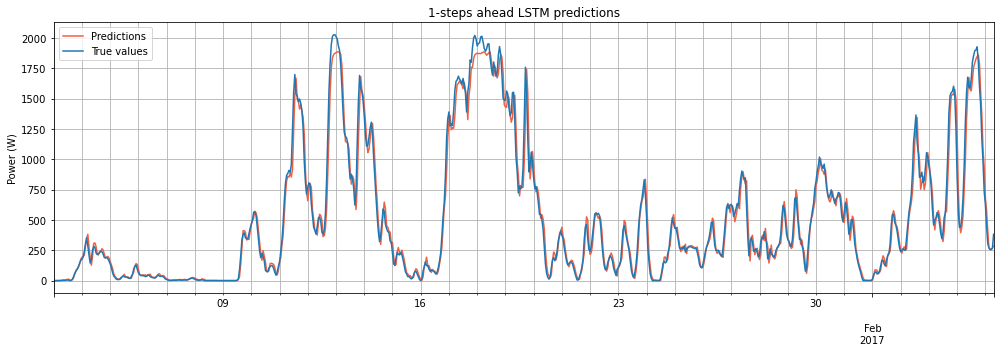

In [10]:
# rescale true values back
true = scaler_output.inverse_transform(y_test.reshape(-1,1)).flatten()
# plot predictions
if N_OUT > 1:
    predictions = pd.Series(predictions, index=test_dates[N_PAST:-N_OUT+1])
    true = pd.Series(true, index=test_dates[N_PAST:-N_OUT+1])
else:
    predictions = pd.Series(predictions, index=test_dates[N_PAST:])
    true = pd.Series(true, index=test_dates[N_PAST:])
processing.plot_series_predictions(true, predictions, N_OUT=N_OUT, method='LSTM')